# Plot TC track in ACE2
2025.1.23
Mu-Ting Chien

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.util as cartopy_util
import cartopy.crs as ccrs
from netCDF4 import Dataset
import os

In [9]:
DIR = '/barnes-engr-scratch1/c832572266/'
dir_in = DIR + 'data_output/ace2/ace2_tempex/StichNodes/'
expname_list = list(['ace2'])
fig_dir_era5 = DIR + 'figure/era5_TC/1deg/'
os.makedirs(fig_dir_era5, exist_ok=True)
file_dir_multi_yr = DIR + 'data_output/ace2/ace2_output/repeat_2001-2010/'

In [39]:
for first_time_execution in range(1,-1,-1):
    print(first_time_execution)
    for icase in range(0,1):
        expname = expname_list[icase]
        fig_dir = DIR + 'figure/ace2_fig/TC/'
        os.makedirs(fig_dir, exist_ok=True)

        # Name of the sub directory for the data named "filename"
        dir_sub_list = np.arange(2001, 2011)

        nsub = np.size(dir_sub_list)
        for imem in range(0, 1):#nmem):
            mem_str = f"{imem+1:02d}"
            for isub in range(0, 1):#nsub): # only plot 2001 for now
                yrname = f"{dir_sub_list[isub]:04d}"

                #filename = 'tracks.ACE2.TC.10yr.'+yrname+'.txt'
                filename = 'tracks.ACE2.TC.10yr.'+yrname+'.wind10m.txt'

                # Define expected number of columns in your data rows
                expected_columns = 12  # Adjust this based on your actual data

                # Define a list to hold valid data rows
                data_rows = []

                # Read file line by line
                with open(dir_in+filename, "r") as file:
                    for line in file:
                        # Split the line by whitespace
                        columns = line.strip().split()
                        
                        # Check if the line matches the expected column count
                        if len(columns) == expected_columns:
                            try:
                                # Attempt to convert the first value to a float (filter out header rows)
                                float(columns[0])
                                data_rows.append(columns)  # Only append if it's not a header
                            except ValueError:
                                # Skip the line if the first item is not numeric (header row)
                                continue

                # Convert the filtered rows to a DataFrame
                data = pd.DataFrame(data_rows, dtype=float)


                # If you want to assign each column to a separate variable
                lon_TC, lat_TC, mslp, vmax, hsfc, vmax_10m = data[2], data[3], data[4], data[5], data[6], data[7]  # Adjust depending on the number of columns
                yr, mon, day, hr           = data[8], data[9], data[10], data[11]

                if isub == 0:
                    ist = 0
                    if first_time_execution == 1:
                        TC_snapshot = np.empty(nsub, dtype=int)
                TC_snapshot[isub] = np.size(lon_TC)
            
                # Save data
                # Note: the year information here all represents 2001 in reality
                np.savez(file_dir_multi_yr+'TC_10yr_'+yrname+'.wind10m.npz', lon_TC = lon_TC, lat_TC=lat_TC, mslp=mslp, vmax=vmax,\
                    vmax_10m=vmax_10m, hsfc=hsfc, yr=yr, mon=mon, day=day, hr=hr)
            
            ntc = np.sum(TC_snapshot)



1
0


In [40]:
print(np.min(hsfc), np.max(hsfc))

print(np.mean(hsfc))

-21.79965 1690.269
13.58050244109979


In [26]:
# Load normal lon and lat 
file = DIR + 'data_output/ace_forcing/HGTsfc.nc'
data = xr.open_dataset(file)
lon = data['lon']
lat = data['lat']

In [41]:
lon_TC_adj = np.where(lon_TC>180, -360+lon_TC, lon_TC)

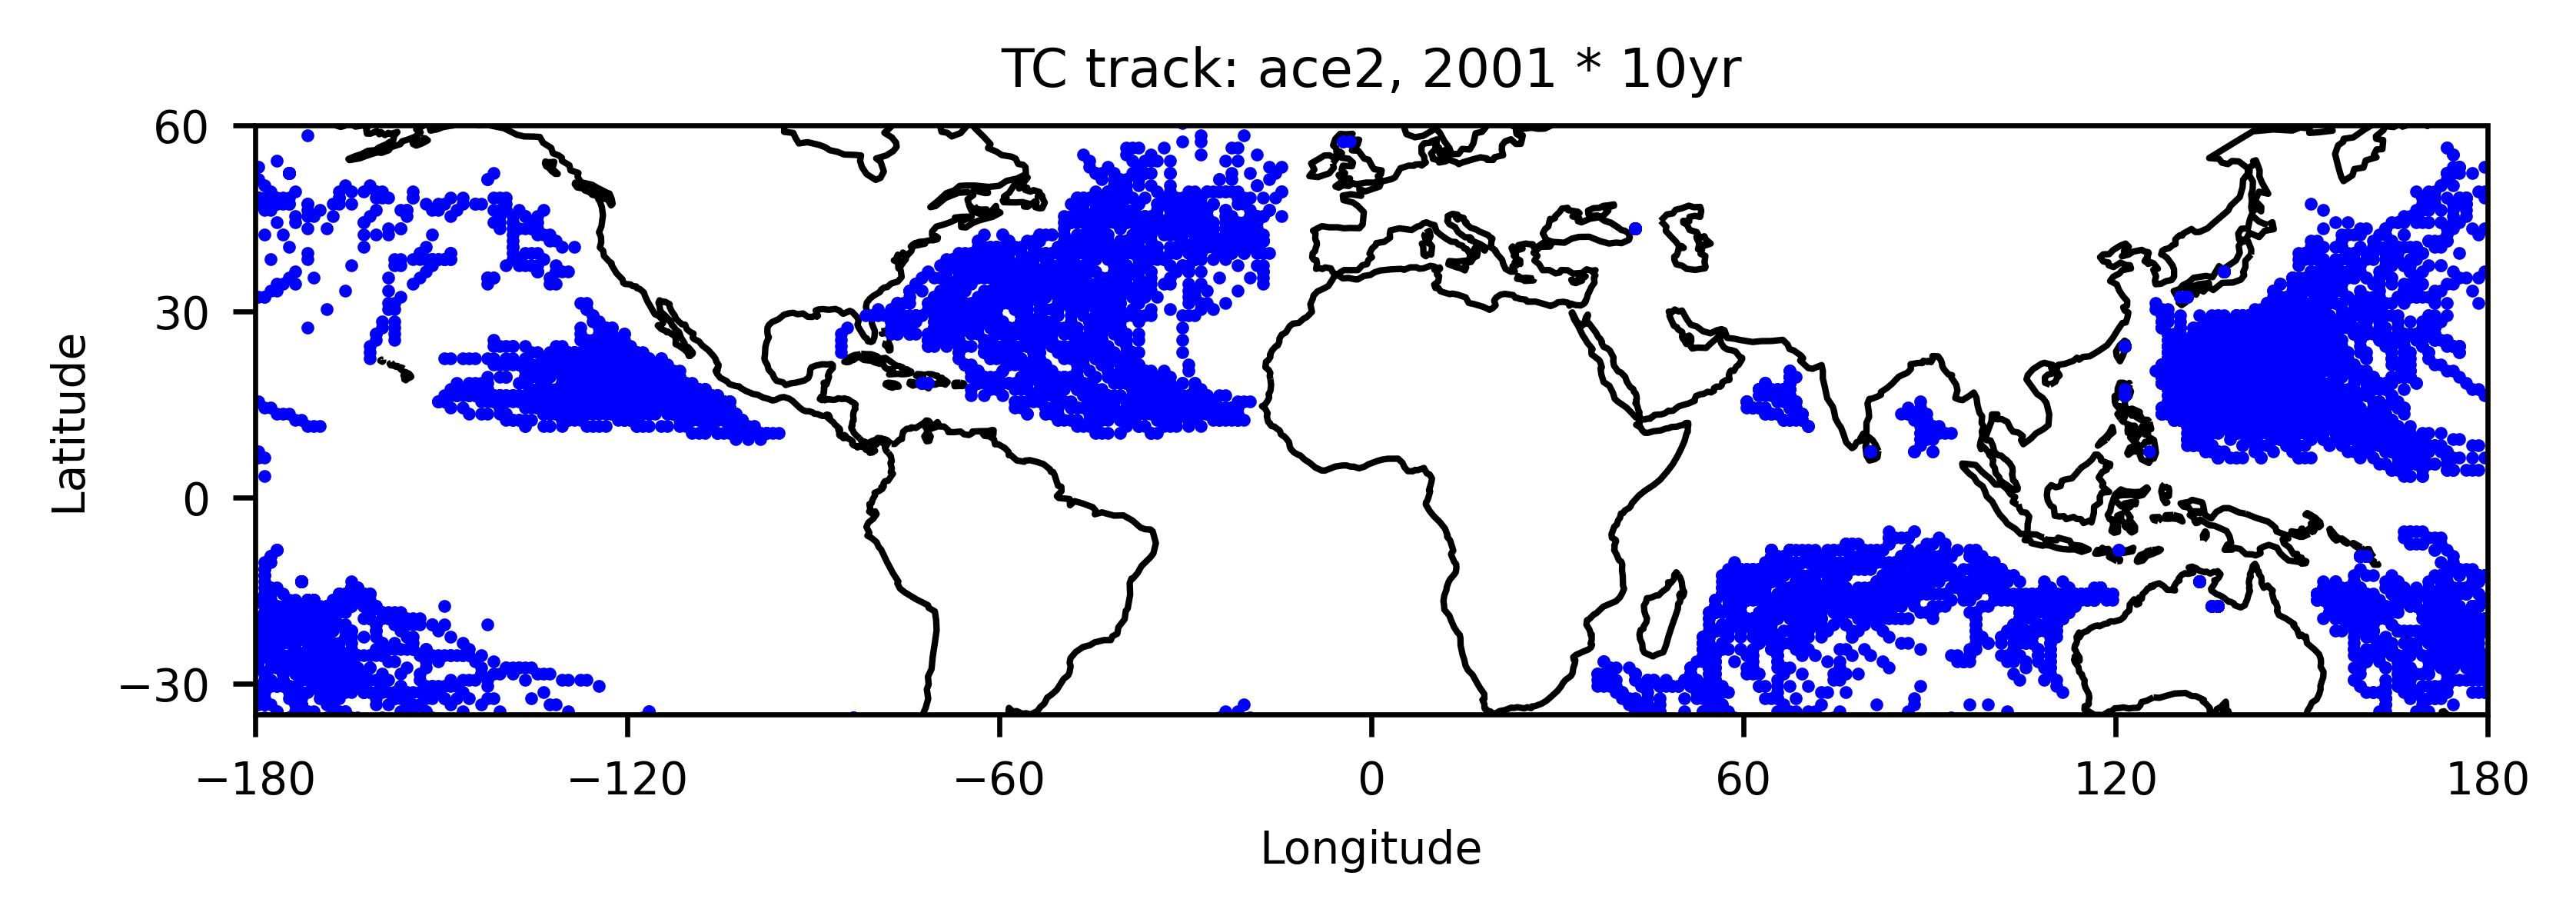

In [42]:
# Plot TC tracks
for isub in range(0, 1):#nsub):
    yrname = f"{dir_sub_list[isub]:04d}"
    fig_name = 'Fig.3_TCtrack_10yr_'+yrname+'.wind10m.png' #'_'+yrname+'.png'

    fig, ax = plt.subplots(1,1,figsize=(5.5, 3.5),dpi=600, subplot_kw={'projection':ccrs.PlateCarree()} )
    plt.subplots_adjust(left=0.1, right=0.98,top=0.9,bottom=0.15,hspace=0.3, wspace=0.1)
    plt.rcParams.update({'font.size': 7})

    [xx, yy] = np.meshgrid(lon, lat)
    ax.coastlines()
    ax.set_xticks(np.arange(-180,240,60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-30,120,30), crs=ccrs.PlateCarree())
    ax.set_ylim(np.array([-35, 60]))

    plt.plot(lon_TC_adj, lat_TC, 'bo', markersize=1)
    plt.title('TC track: '+expname+', '+yrname+' * 10yr')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(fig_dir+fig_name,format='png', dpi=600)
    plt.show()

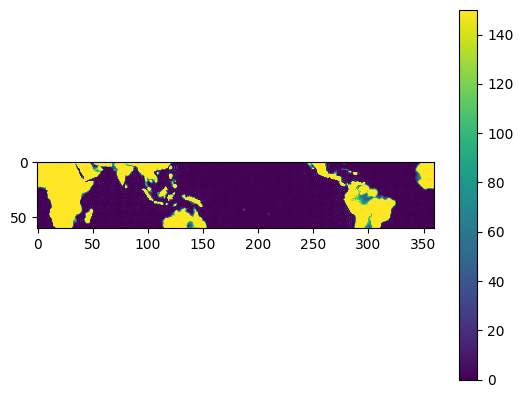

In [12]:
# Test: check surface height
file_name = '/barnes-engr-scratch1/c832572266/data_output/ace_forcing/HGTsfc.nc'
ds = xr.open_dataset(file_name)
ds = ds.sel(lat=slice(-30,30))
hsfc = ds['HGTsfc']
plt.imshow(hsfc[::-1,:], vmin=0, vmax=150)
plt.colorbar()
plt.show()

# Plot TC intensity statistics

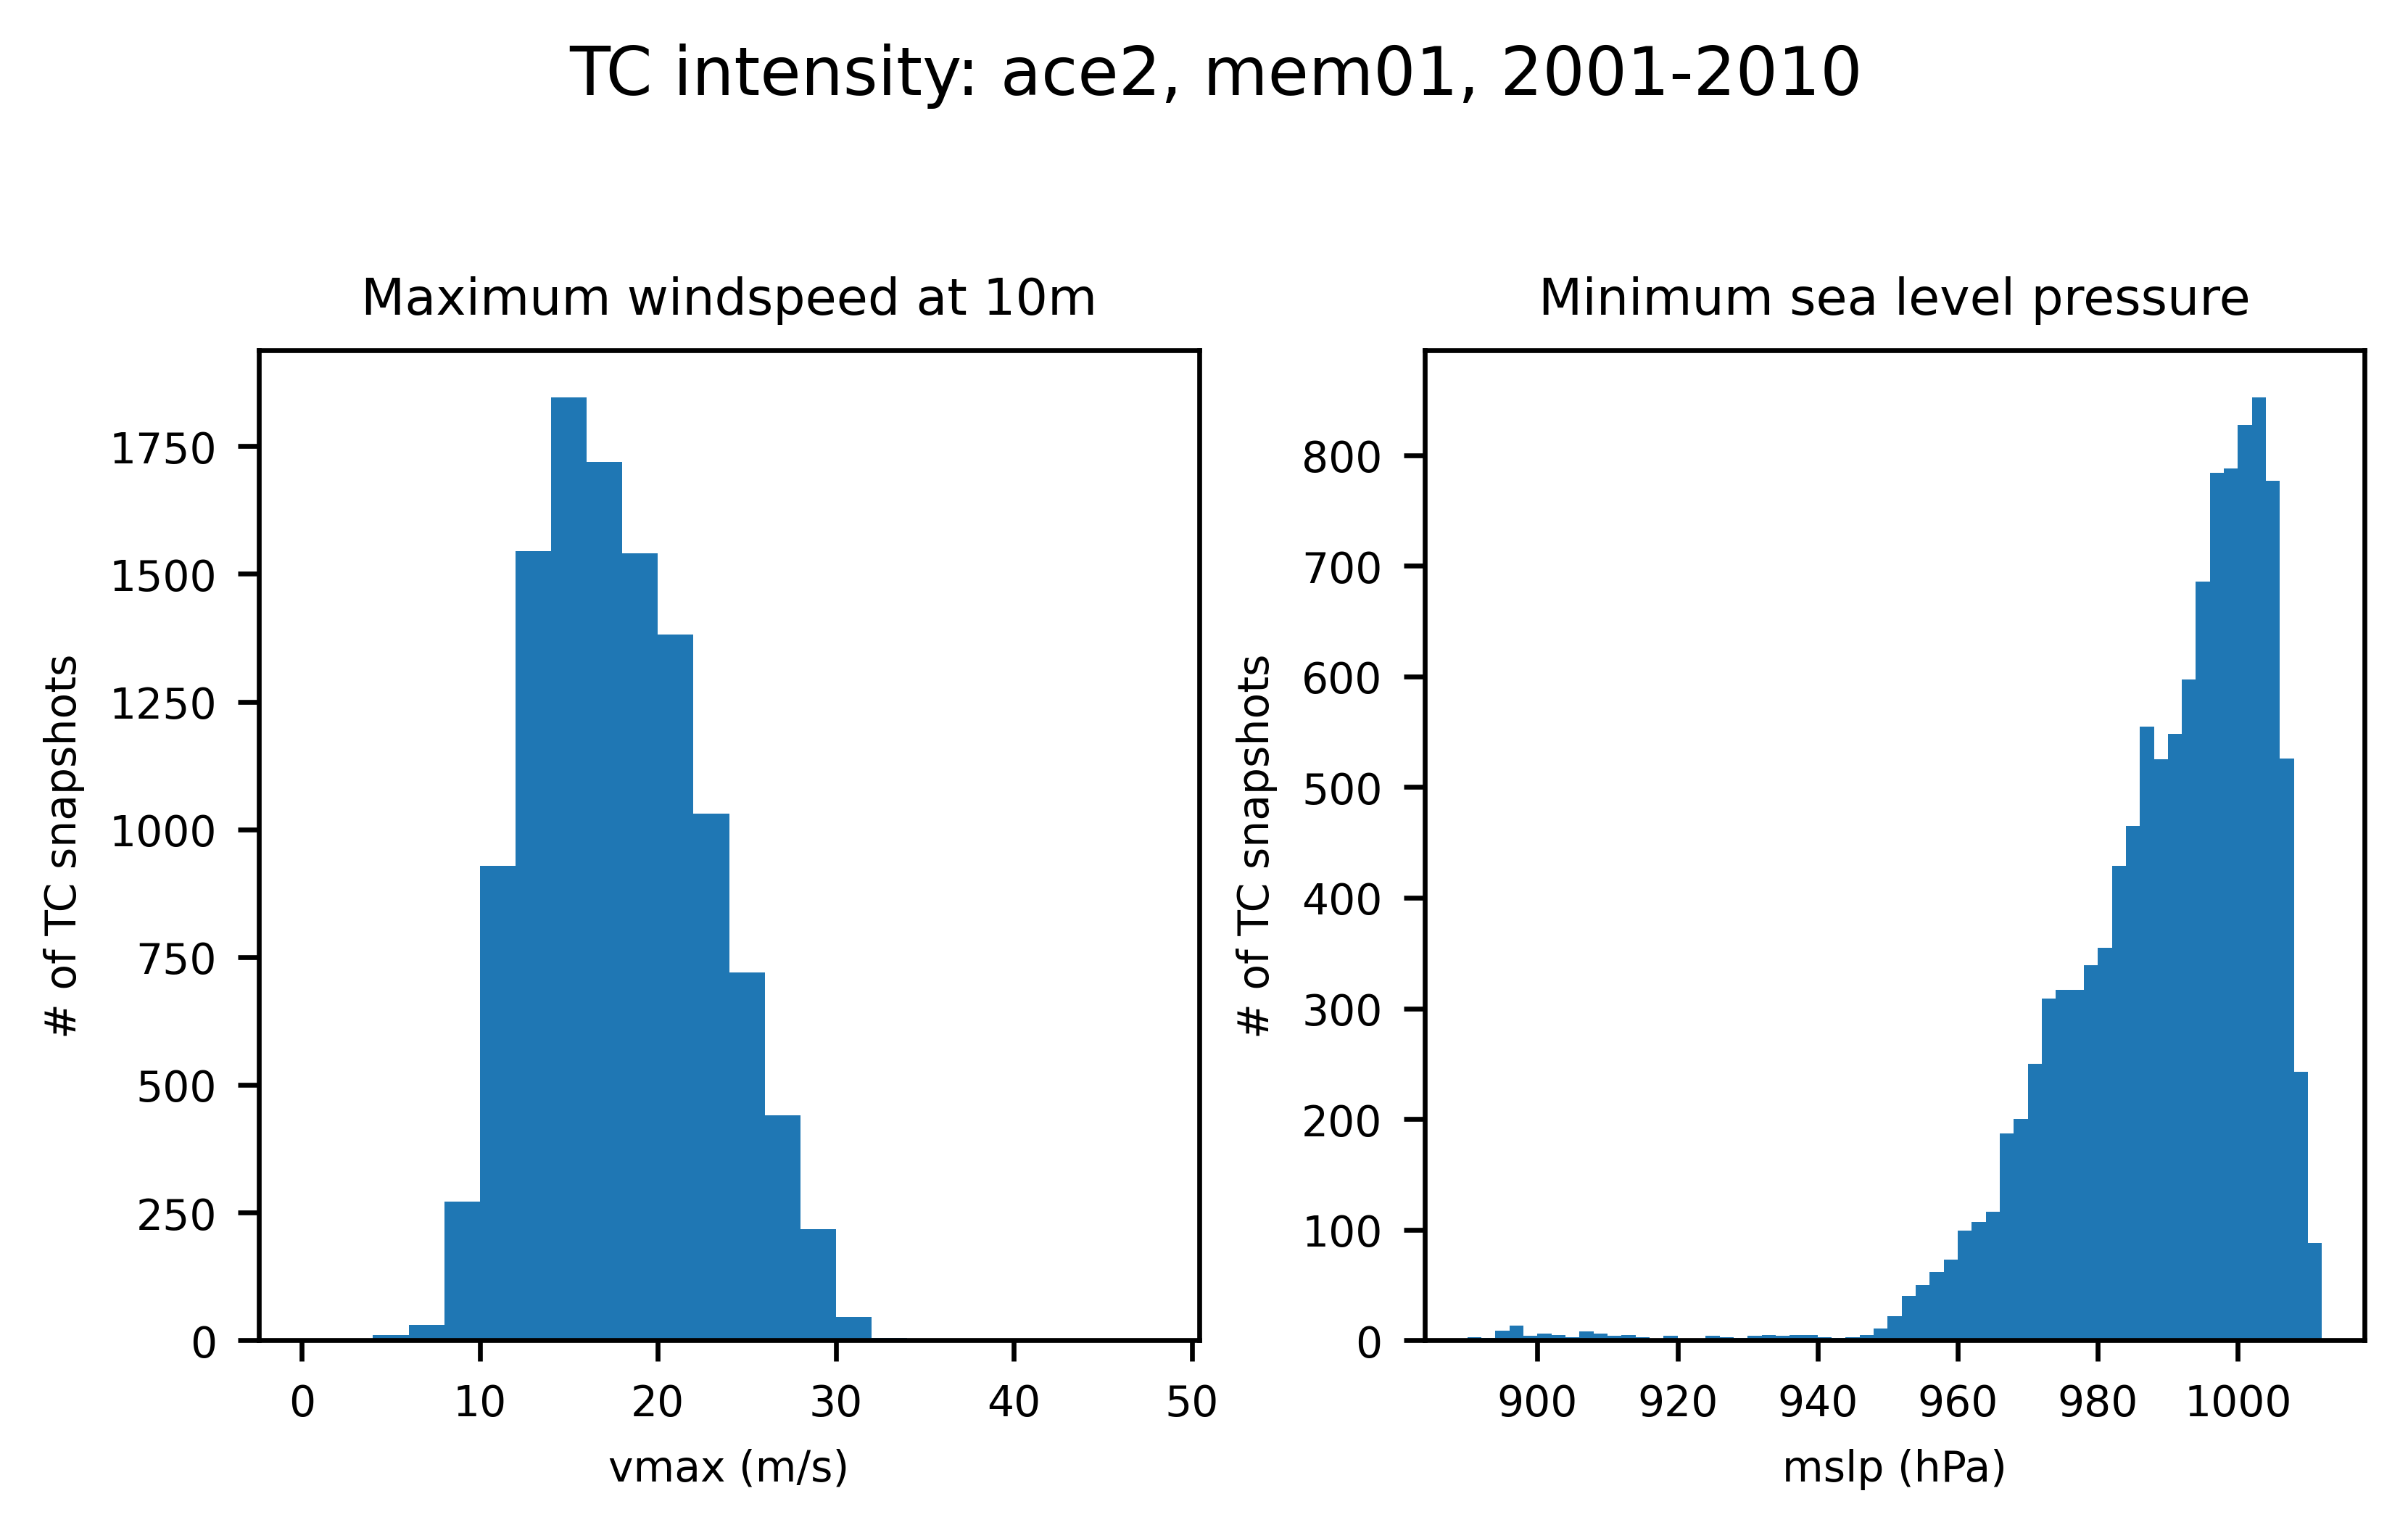

In [41]:
fig_name = 'Fig.4_TC_intensity_histogram_mem'+mem_str+'_U10V10.png' #'_'+yrname+'.png'
fig, ax = plt.subplots(1,2,figsize=(5.5, 3.5),dpi=600)
plt.subplots_adjust(left=0.1, right=0.98,top=0.8,bottom=0.15,hspace=0.3, wspace=0.24)
plt.rcParams.update({'font.size': 7})
plt.suptitle('TC intensity: '+expname+', mem'+mem_str+', 2001-2010', y=1.002, fontsize=11 )
#
plt.subplot(1,2,1)
plt.title('Maximum windspeed at 10m')
plt.hist(vmax_10m_all, bins = np.arange(0,50,2))
plt.xlabel('vmax (m/s)')
plt.ylabel('# of TC snapshots')
#
plt.subplot(1,2,2)
plt.title('Minimum sea level pressure')
plt.hist(mslp_all/100, bins = np.arange(890,1014,2))
plt.xlabel('mslp (hPa)')
plt.ylabel('# of TC snapshots')
plt.savefig(fig_dir+fig_name,format='png', dpi=600)
plt.show()

# ERA5 TC data

In [6]:
# Load ERA5 TC data (from Jihong: UW server: /home/disk/eos4/moon/tempex/sensitivity/ERA5TC/StitchNodes/)
g = 9.8
nyr = 10
#dir_in_era5 = DIR + 'data_output/TC_ERA5/'
#dir_in_era5 = DIR + 'data_output/ERA5TC_fromJihong/'
dir_in_era5 = DIR + 'data_output/ERA5TC_muting/StichNodes/'
for first_time_execution in range(1,-1,-1):
    for iyr in range(0, nyr):
        yrname = str(iyr+2001)
        filename = 'tracks.ERA5.TC.'+yrname+'.txt'

        # Define expected number of columns in your data rows
        expected_columns = 11  # Adjust this based on your actual data

        # Define a list to hold valid data rows
        data_rows = []

        # Read file line by line
        with open(dir_in_era5 + filename, "r") as file:
            for line in file:
                # Split the line by whitespace
                columns = line.strip().split()
                        
                # Check if the line matches the expected column count
                if len(columns) == expected_columns:
                    try:
                    # Attempt to convert the first value to a float (filter out header rows)
                        float(columns[0])
                        data_rows.append(columns)  # Only append if it's not a header
                    except ValueError:
                        # Skip the line if the first item is not numeric (header row)
                        continue

        # Convert the filtered rows to a DataFrame
        data = pd.DataFrame(data_rows, dtype=float)


        # If you want to assign each column to a separate variable
        lon_TC, lat_TC, mslp, vmax, hsfc = data[2], data[3], data[4], data[5], data[6]  # Adjust depending on the number of columns
        yr, mon, day, hr           = data[7], data[8], data[9], data[10]

        
        if iyr == 0:
            ist = 0
            TC_snapshot = np.empty([nyr], dtype=int)
        TC_snapshot[iyr] = np.size(lon_TC)

        if first_time_execution == 0:
            
            if iyr == 0:
                lon_TC_era5 = np.empty([ntc_era5]) #note that 4916 is the sum of TC_snapshot for 3 years, change this if different exp (mem)
                lat_TC_era5 = np.empty([ntc_era5])
                mslp_era5 = np.empty([ntc_era5])
                vmax_era5 = np.empty([ntc_era5])
                hsfc_era5 = np.empty([ntc_era5])
                yr_era5 = np.empty([ntc_era5])
                mon_era5 = np.empty([ntc_era5])
                day_era5 = np.empty([ntc_era5])
                hr_era5 = np.empty([ntc_era5])

            lon_TC_era5[ist:ist+TC_snapshot[iyr]] = lon_TC
            lat_TC_era5[ist:ist+TC_snapshot[iyr]] = lat_TC
            mslp_era5[ist:ist+TC_snapshot[iyr]] = mslp
            vmax_era5[ist:ist+TC_snapshot[iyr]] = vmax
            hsfc_era5[ist:ist+TC_snapshot[iyr]] = hsfc
            yr_era5[ist:ist+TC_snapshot[iyr]] = yr
            mon_era5[ist:ist+TC_snapshot[iyr]] = mon
            day_era5[ist:ist+TC_snapshot[iyr]] = day
            hr_era5[ist:ist+TC_snapshot[iyr]] = hr

        ist = ist + TC_snapshot[iyr]
    
    if first_time_execution == 1:
        ntc_era5 = np.sum(TC_snapshot)
        print(ntc_era5)

np.savez(dir_in_era5+'TC_era5_2001-2010_1deg.npz', lon_TC = lon_TC, lat_TC=lat_TC, mslp=mslp, vmax=vmax,\
                        hsfc=hsfc/g, yr=yr, mon=mon, day=day, hr=hr)

15314


In [7]:
lon_TC_adj_era5 = np.where(lon_TC_era5>180, -360+lon_TC_era5, lon_TC_era5)

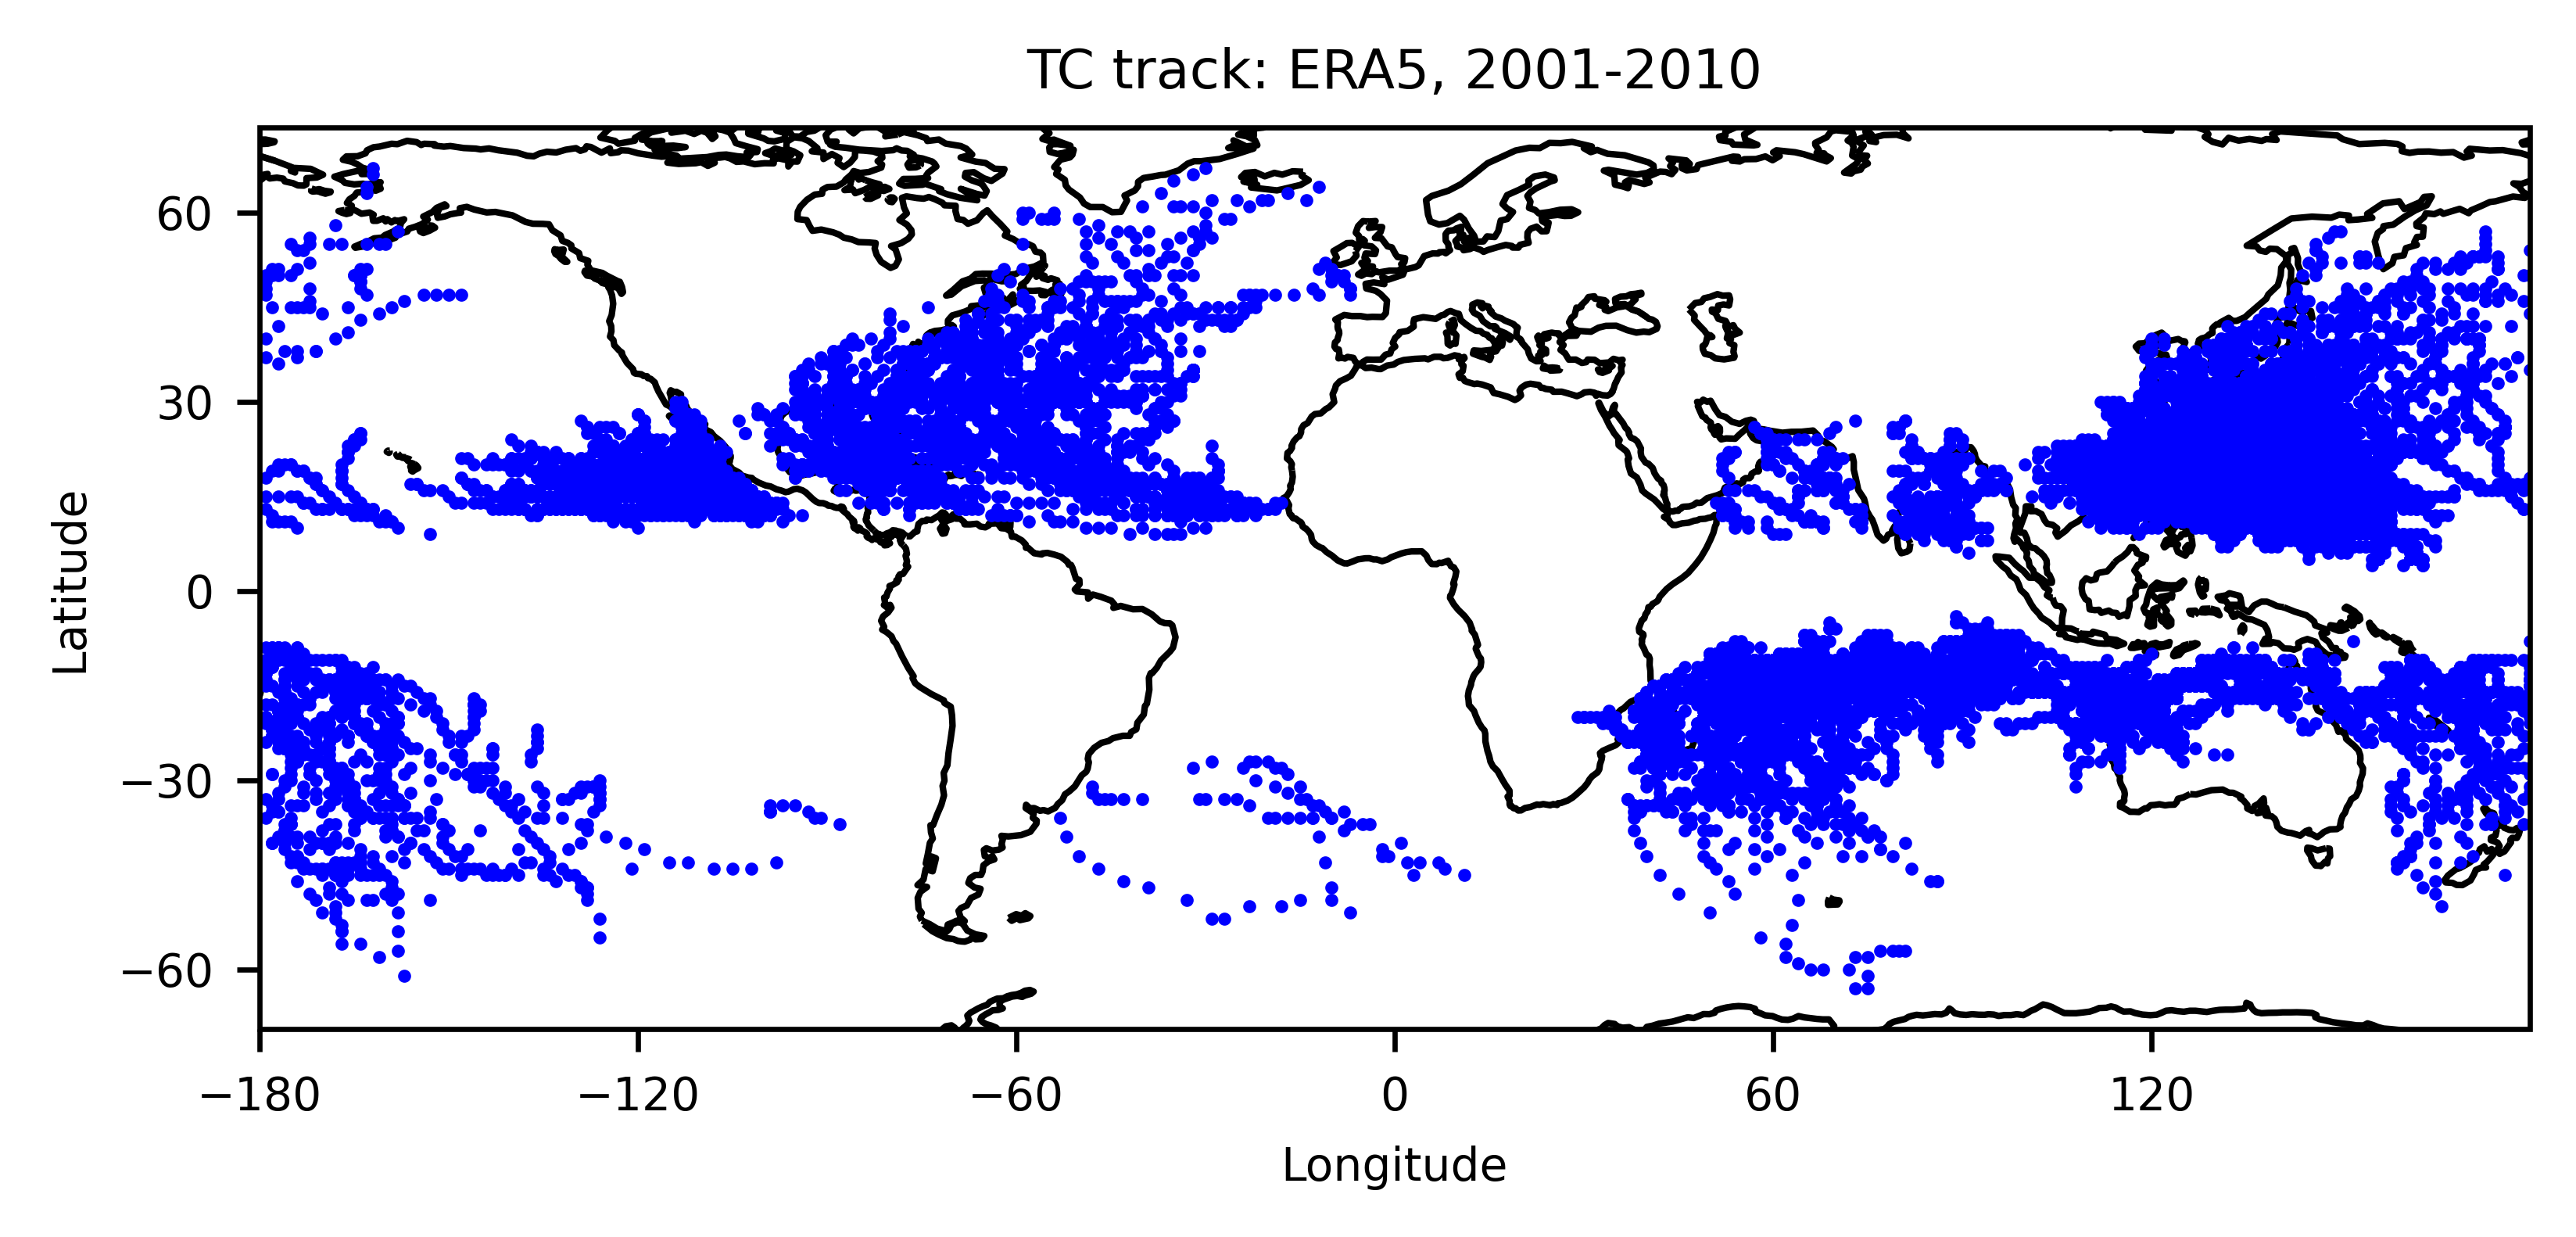

In [13]:
# Plot TC tracks from ERA5
for i in range(0,1):
    fig_name = 'Fig.3_TCtrack_ERA5_2001-2010_1deg.png' #'_'+yrname+'.png'

    fig, ax = plt.subplots(1,1,figsize=(5.5, 3.5),dpi=600, subplot_kw={'projection':ccrs.PlateCarree()} )
    plt.subplots_adjust(left=0.1, right=0.98,top=0.9,bottom=0.15,hspace=0.3, wspace=0.1)
    plt.rcParams.update({'font.size': 7})

    ax.coastlines()
    ax.set_xticks(np.arange(-180,180,60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90,120,30), crs=ccrs.PlateCarree())

    plt.plot(lon_TC_adj_era5, lat_TC_era5, 'bo', markersize=1)
    plt.title('TC track: ERA5, 2001-2010')#+yrname)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(fig_dir_era5+fig_name,format='png', dpi=600)
    plt.show()

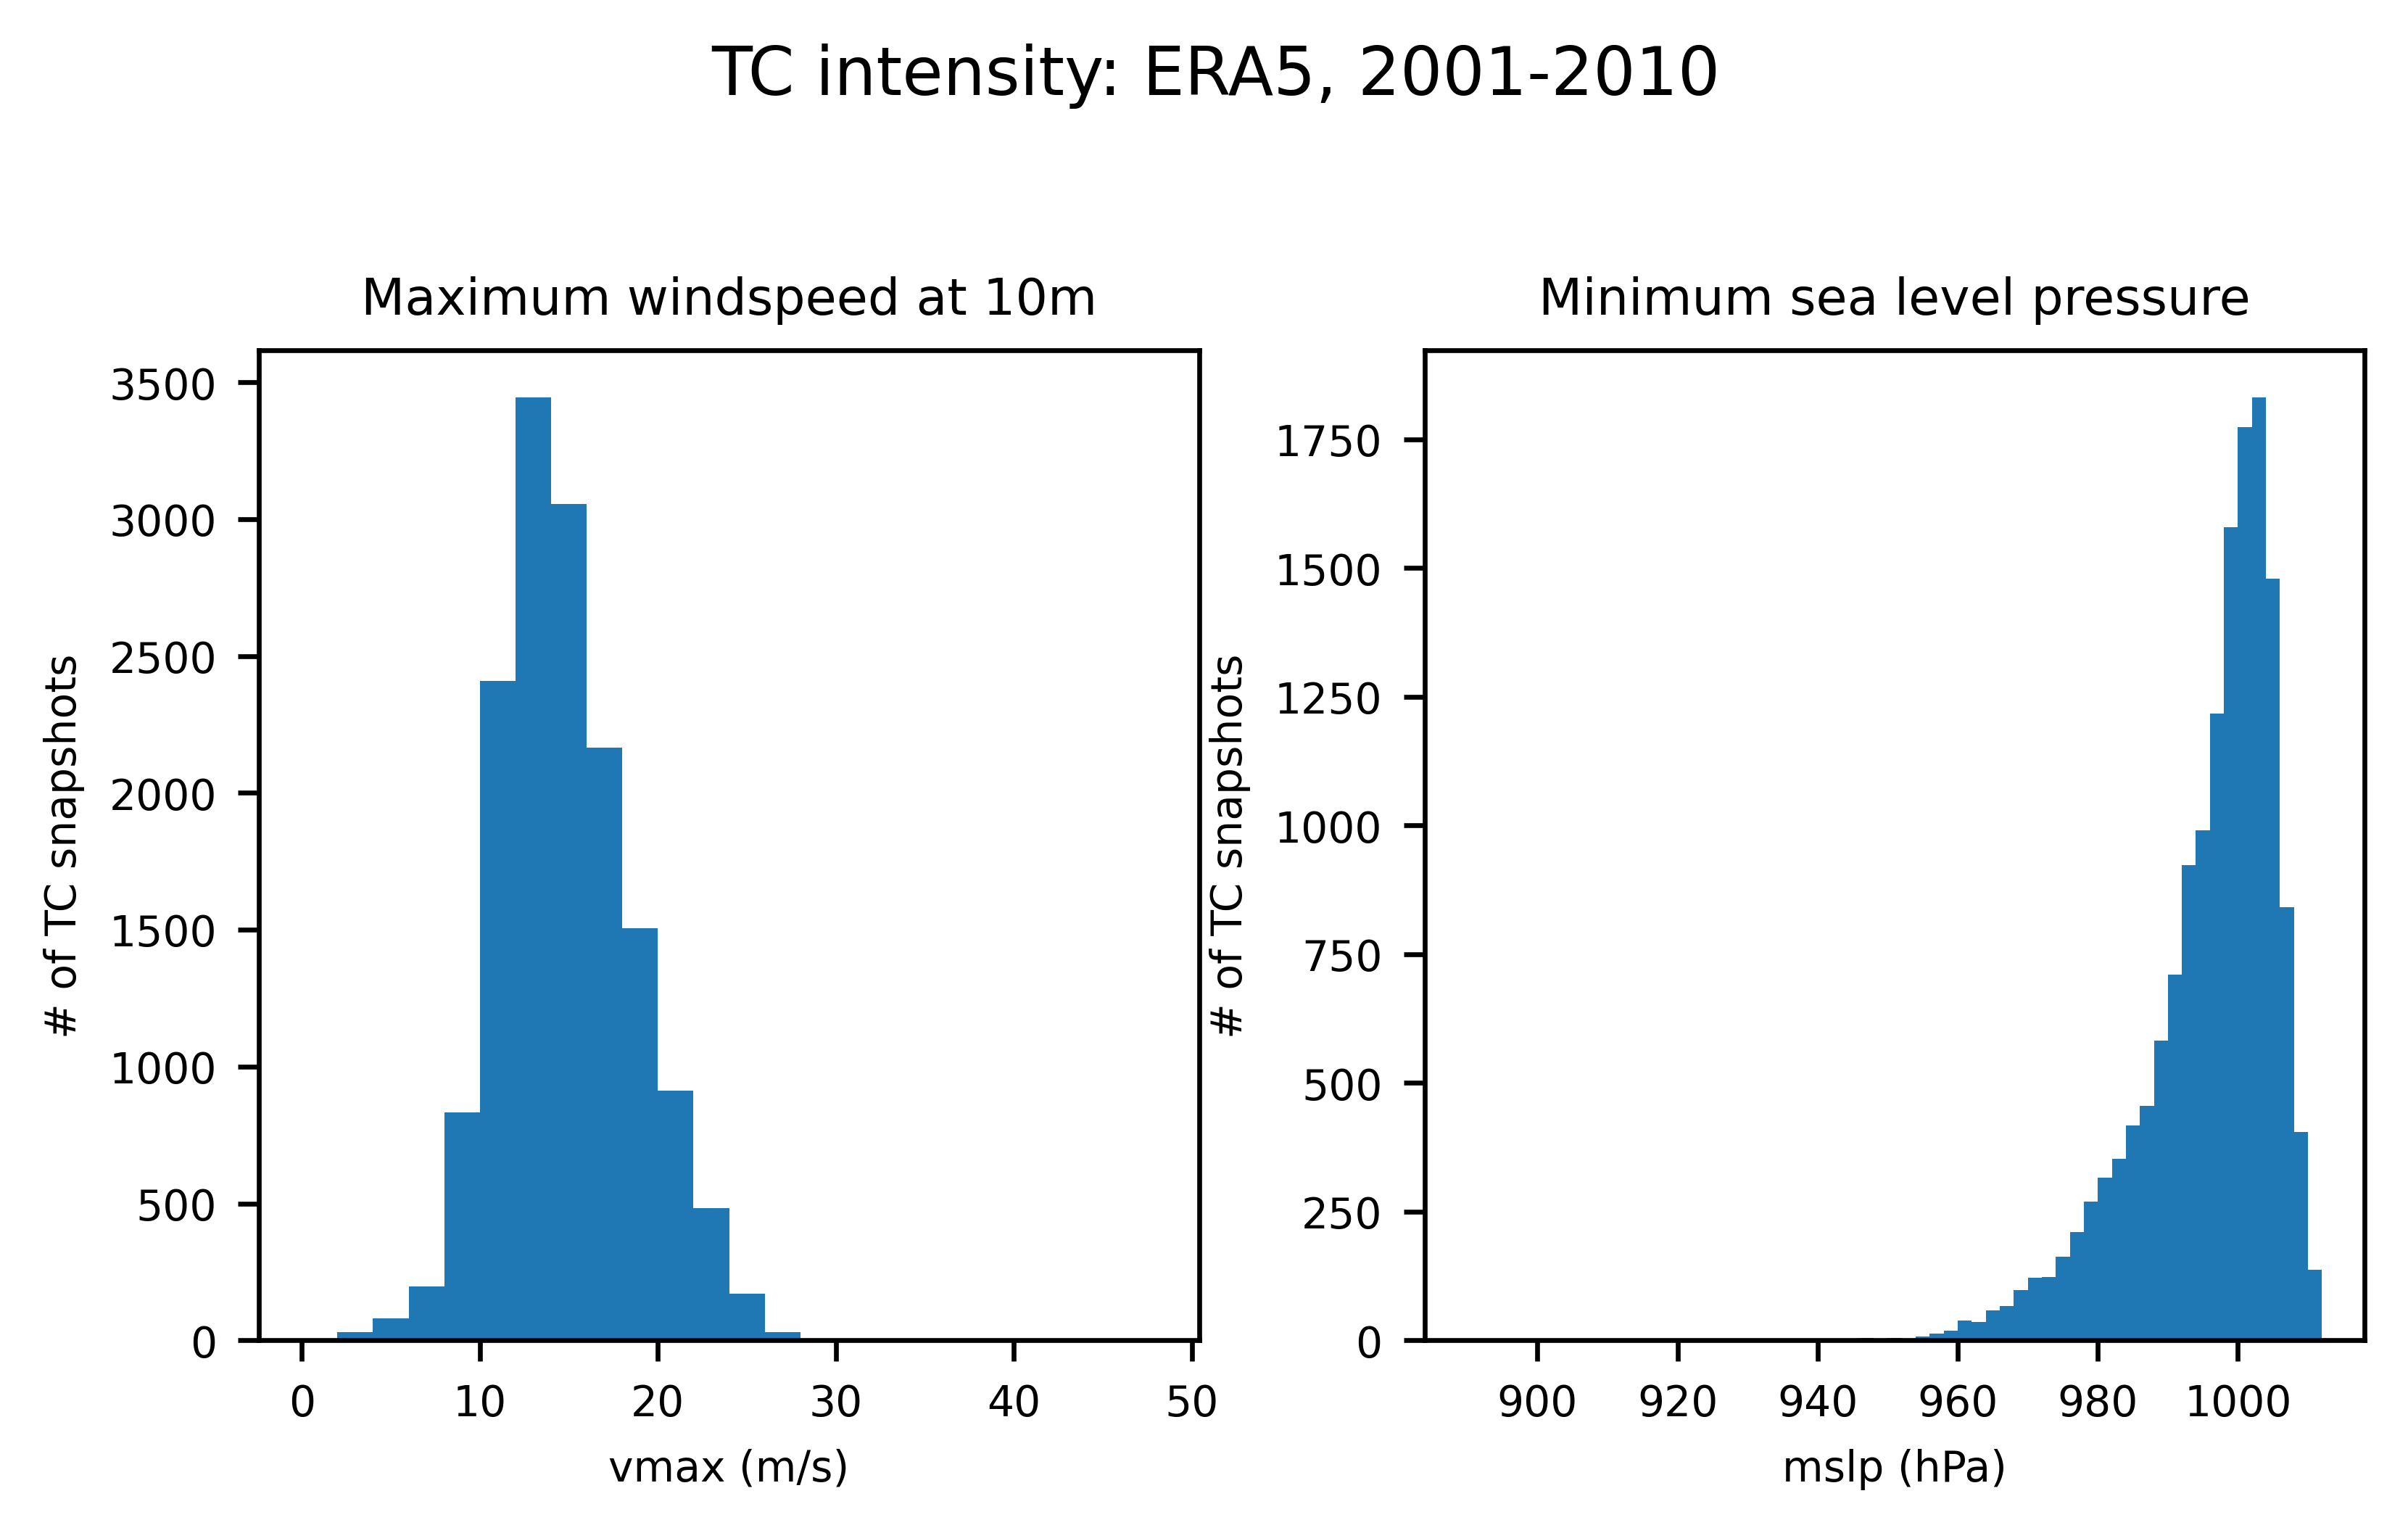

In [14]:
# Plot intensity from ERA5
fig_name = 'Fig.4_TC_intensity_histogram_era5_2001-2010.png' #'_'+yrname+'.png'
fig, ax = plt.subplots(1,2,figsize=(5.5, 3.5),dpi=600)
plt.subplots_adjust(left=0.1, right=0.98,top=0.8,bottom=0.15,hspace=0.3, wspace=0.24)
plt.rcParams.update({'font.size': 7})
plt.suptitle('TC intensity: ERA5, 2001-2010', y=1.002, fontsize=11 )
#
plt.subplot(1,2,1)
plt.title('Maximum windspeed at 10m')
plt.hist(vmax_era5, bins = np.arange(0,50,2))
#plt.xlim([0,40])
plt.xlabel('vmax (m/s)')
plt.ylabel('# of TC snapshots')
#
plt.subplot(1,2,2)
plt.title('Minimum sea level pressure')
plt.hist(mslp_era5/100, bins = np.arange(890,1014,2))
plt.xlabel('mslp (hPa)')
plt.ylabel('# of TC snapshots')
plt.savefig(fig_dir_era5+fig_name,format='png', dpi=600)
plt.show()